In [8]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_10108/440907590.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [9]:
x=np.linspace(-5,5,91)
X,Y=np.meshgrid(x,x)
# 91x91 each

nGauss=2000
widths = np.linspace(2,20,nGauss)

picNoOcc=torch.zeros(nGauss,1,91,91)
picOcc=torch.zeros(nGauss,1,91,91)
for i in range(nGauss):
  ro=np.random.randn(2)
  G=np.exp(-(((X-ro[0])**2)+(Y-ro[1])**2)/widths[i])
  G=G+np.random.randn(91,91)/5
  picNoOcc[i]=torch.Tensor(G)
  i1 = np.random.choice(np.arange(0,91))
  i2 = np.random.choice(np.arange(2,7))

  if np.random.randn():
    G[i1:i1+i2,]=1

  else:
    G[:,i1:i1+i2]=1
  picOcc[i]=torch.Tensor(G)


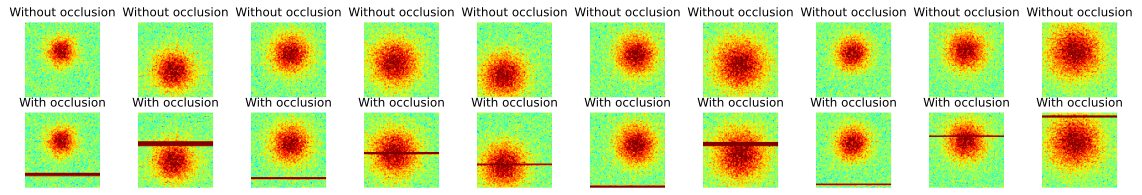

In [10]:
idsToVisualize=np.random.choice(nGauss,size=32,replace=False)
fig,axs=plt.subplots(2,10,figsize=(20,3))

for i in range(10):
  axs[0,i].imshow(torch.squeeze(picNoOcc[idsToVisualize[i]]),vmin=-1,vmax=1,cmap='jet')
  axs[0,i].set_title('Without occlusion')
  axs[0,i].axis('off')

  axs[1,i].imshow(torch.squeeze(picOcc[idsToVisualize[i]]),vmin=-1,vmax=1,cmap='jet')
  axs[1,i].set_title('With occlusion')
  axs[1,i].axis('off')
plt.show()


In [14]:
def modelCreation():
    class CNNAutoEncodernet(nn.Module):
        def __init__(self):
            super().__init__()
            # call the constructor of the base class nn.Module
            # encoding layer
            self.enc = nn.Sequential(
                nn.Conv2d(1,6,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.Conv2d(6,4,3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2,2)
                )

            # decoding layer
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(4,6,3,2),
                nn.ReLU(),
                nn.ConvTranspose2d(6,1,3,2),
                )
        def forward(self,x):
            return self.dec(self.enc(x))
    CNNnet=CNNAutoEncodernet()
    optimizer=torch.optim.Adam(CNNnet.parameters(),lr=.001)
    lossFun=nn.MSELoss()
    return CNNnet,lossFun,optimizer

In [15]:
# a function that trains the model

def trainModal():
  numepochs = 1000
  CNNnet,lossFun,optimizer = modelCreation()
  losses = torch.zeros(numepochs)

  for epochi in range(numepochs):
    IndexesOfRandomPics = np.random.choice(nGauss,size=32,replace=False)

    X = picOcc[IndexesOfRandomPics,:,:,:]
    Y = picNoOcc[IndexesOfRandomPics,:,:,:]
    # input with occ and the target no occ

    # forward pass 
    yHat = CNNnet(X)
    loss = lossFun(yHat,Y)
    losses[epochi] = loss.item()

    # back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


  return losses,CNNnet

In [ ]:
losses,CNNnet=trainModal()


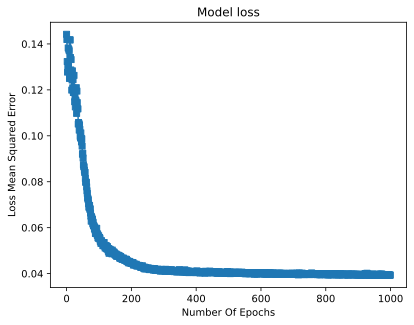

In [17]:
plt.plot(losses,'s-',label='Train')
plt.xlabel('Number Of Epochs')
plt.ylabel('Loss Mean Squared Error')    
plt.title('Model loss')
plt.show()

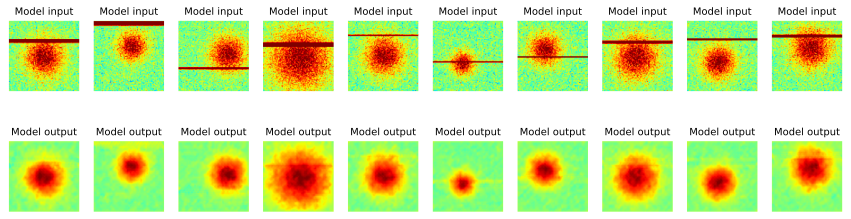

In [21]:

IndexesOfRandomPics = np.random.choice(nGauss,size=20,replace=False)
X = picOcc[IndexesOfRandomPics,:,:,:]
yHat = CNNnet(X)
fig,axs = plt.subplots(2,10,figsize=(15,4))
for i in range(10):

  G = torch.squeeze( X[i,0] ).detach()
  O = torch.squeeze( yHat[i,0] ).detach()

  axs[0,i].imshow(G,vmin=-1,vmax=1,cmap='jet')
  axs[0,i].axis('off')
  axs[0,i].set_title('Model input',fontsize=10)

  axs[1,i].imshow(O,vmin=-1,vmax=1,cmap='jet')
  axs[1,i].axis('off')
  axs[1,i].set_title('Model output',fontsize=10)

plt.show()